In [57]:
import sys
sys.path.append('../../')
import numpy as np
import importlib
from models.utils import dataloader as u
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit
import scipy.stats as stats
importlib.reload(u)

<module 'models.utils.dataloader' from '../..\\models\\utils\\dataloader.py'>

In [58]:
def smooth_timeseries(t, size=5, axis=0):
    '''Smooth the function by taking a moving average of "size" time steps'''
    average_filter = np.full((size, ), 1 / size)

    t = np.pad(t, [(size // 2 + (not size % 2), size // 2)], mode='median', stat_length=size)
    return np.apply_along_axis(lambda r: np.convolve(r, average_filter, mode='valid'), 
        axis=axis, arr=t)

In [59]:
def smooth_timeseries2(t, size=5):
    '''Smooth the function by taking a moving average of "size" time steps'''
    average_filter = np.full((size, ), 1 / size)
    t = np.pad(t, [(0, 0), (size // 2 + (not size % 2), size // 2)], mode='median', 
            stat_length=size)
    return np.apply_along_axis(lambda r: np.convolve(r, average_filter, mode='valid'),
        axis=1, arr=t)


In [60]:
datadict = u.load_covid_timeseries(smoothing=3, cases_cutoff=5)
cases_all = datadict['cases_raw']
deaths_all = datadict['deaths_raw']

In [61]:
demographics = u.load_demographics_data()
pop = demographics['total_pop']

In [62]:
county = 1858
cases_raw = cases_all[county] 
deaths_raw = deaths_all[county]

b = deaths_raw != 0
deaths_raw = deaths_raw[b]
cases_raw = cases_raw[b]

cases = np.diff(cases_raw)
deaths = np.diff(deaths_raw)

s = 7
cases_smooth = smooth_timeseries(cases, s)
deaths_smooth = smooth_timeseries(deaths, s)

z = deaths_smooth

In [78]:
#counties = [2579, 2742, 2623, 2565, 2583]
# Travis, Dallas, Dallas, Tarrant, Harris, Bexar, Lubbock: [2749, 2579, 2742, 2623, 2537, 2674]
# Somerset, Union, Essex, Hudson, Bergen
counties =  [1791, 1793, 1780, 1782, 1775] 
cases_raw = np.array([cases_all[county] for county in counties])
deaths_raw = np.array([deaths_all[county] for county in counties])

# b = deaths_raw != 0
# deaths_raw = deaths_raw[b]
# cases_raw = cases_raw[b]

cases = np.diff(cases_raw, axis=1)
deaths = np.diff(deaths_raw, axis=1)

s = 7
cases_smooth = smooth_timeseries2(cases, s)
deaths_smooth = smooth_timeseries2(deaths, s)

z = deaths_smooth

print(cases_raw.shape)

(5, 132)


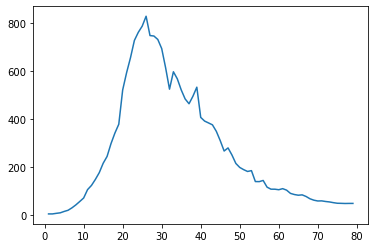

In [63]:
# y = cases_smooth
# x = np.arange(1, y.shape[0] + 1)
# plt.plot(x, y, color='orange')

y = deaths_smooth
x = np.linspace(1, y.shape[0], y.shape[0])
plt.plot(x, y)

# Least Squares fit model

In [64]:
dat = z

validation_steps = 7

X_train = np.arange(dat.shape[0] - validation_steps)
y_train = dat[:dat.shape[0] - validation_steps]

X_test = np.arange(dat.shape[0] - validation_steps, dat.shape[0])
y_test = dat[dat.shape[0] - validation_steps:]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(72,) (72,) (7,) (7,)


In [65]:
def erf_model(x, max_val, loc, scale):
    return max_val*(1 + scipy.special.erf(scale*(x - loc)))

def skew_model(x, max_val, loc, scale, a, shift):
    return max_val * stats.skewnorm.pdf(x, a, loc, scale) + shift

def exp_model(x, max_val, loc, scale, K):
    return max_val*stats.exponnorm.pdf(x, K, loc, scale)

def bimodal_exp_model(x, max_val1, loc1, scale1, K1, max_val2, loc2, scale2, K2):
    return exp_model(x, max_val1, loc1, scale1, K1) + exp_model(x, max_val2, loc2, scale2, K2)

def exp_modelcdf(x, max_val, loc, scale, K):
    return max_val*stats.exponnorm.cdf(x, K, loc, scale)

erf_bounds = ([-np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf])
exp_bounds = ([z.max(), 0, 0, 0], [100*z.max(), np.inf, np.inf, 15])
bimodal_bounds = ([z.max(), 0, 0, 0, z.max(), 30, 10, 0], [100*z.max(), np.inf, np.inf, 15, 65*z.max(), np.inf, np.inf, 15])

model = exp_model
bounds = exp_bounds
popt, pcov = curve_fit(model, X_train, y_train, bounds=bounds)

In [66]:
print(popt)

[2.14284089e+04 1.88035651e+01 5.33121411e+00 3.04284015e+00]


In [67]:
errors = np.sqrt(np.diag(pcov))
print(errors)

[3.08318423e+02 1.95615927e-01 2.16176223e-01 2.03102707e-01]


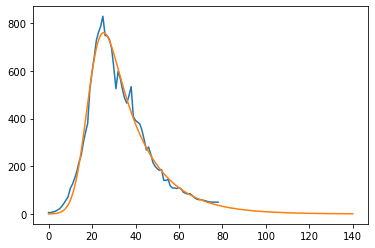

In [68]:
d = deaths_smooth
x = np.linspace(0, d.shape[0] - 1, d.shape[0])
y = d
plt.plot(x, y)

x = np.linspace(0, 140, 1000)
y = model(x, *popt)

# xx = np.linspace(0, d.shape[0] + 20, d.shape[0] + 21)
# x = np.arange(0, d.shape[0] + 20)
# y = model(xx, *popt)
# y = np.diff(y)

plt.plot(x, y)
#plt.plot(X_train, y_train, marker='o', linewidth=0)
#plt.plot(X_test, y_test, marker='o', linewidth=0)

# plt.ylim(0, 150)
# plt.xlim(100,)

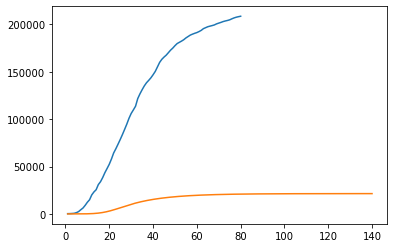

In [69]:
d = cases_raw
x = np.linspace(1, d.shape[0], d.shape[0])
y = d
plt.plot(x, y)

x = np.linspace(1, 140, 1000)
y = exp_modelcdf(x, *popt)
plt.plot(x, y)

# GP for cases -> deaths model

In [70]:
delays = np.arange(1, 15)
corr = []
for delay in delays:
    cases_past = []
    deaths_curr = []
    for i in range(delay, cases_smooth.shape[0]):
        if i < 0.25 * cases_smooth.shape[0]:
            continue
        cases_past.append(cases_smooth[i - delay])
        deaths_curr.append(deaths_smooth[i])
    co = np.corrcoef(cases_past, deaths_curr)[0, 1]
    corr.append(co)

In [29]:
delays = np.arange(1, 15)
corr = []
for delay in delays:
    cases_past = []
    deaths_curr = []
    for county in range(cases_smooth.shape[0]):
        for i in range(delay, cases_smooth.shape[1]):
            if i < 0.25 * cases_smooth.shape[1]:
                continue
            if cases[county, i - delay] == 0:
                continue
            cases_past.append(cases_smooth[county, i - delay])
            deaths_curr.append(deaths_smooth[county, i])
    co = np.corrcoef(cases_past, deaths_curr)[0, 1]
    corr.append(co)

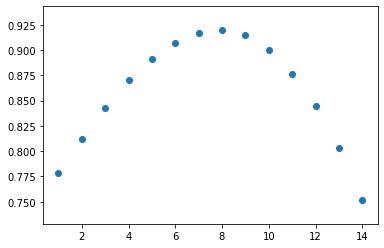

In [30]:
plt.scatter(delays, corr)

In [31]:
best_delays = np.argsort(corr)[::-1] + 1
best_delay = best_delays[best_delays > 5][0]
print(best_delay)

8


In [8]:
best_delay = 14

In [15]:
delay = best_delay
colors = []
cases_past = []
deaths_curr = []
rate = []
for i in range(delay + 1, cases_smooth.shape[0]):
    if i < 0.25 * cases_smooth.shape[0]:
            continue
    cases_past.append(cases_smooth[i - delay])
    deaths_curr.append(deaths_smooth[i])
    rate.append(deaths_smooth[i] / cases_smooth[i - delay])
    colors.append(i)

In [52]:
delay = best_delay
colors = []
cases_past = []
deaths_curr = []
rate = {county : [] for county in range(cases_smooth.shape[0])}
for county in range(cases_smooth.shape[0]):
    for i in range(delay + 1, cases_smooth.shape[1]):
        if i < 0.5 * cases_smooth.shape[1]:
                continue
#         if deaths[county, i - delay] == 0:
#             continue
        cases_past.append(cases_smooth[county, i - delay])
        deaths_curr.append(deaths_smooth[county, i])
        rate[county].append(deaths_smooth[county, i] / cases_smooth[county, i - delay])
        colors.append(county)

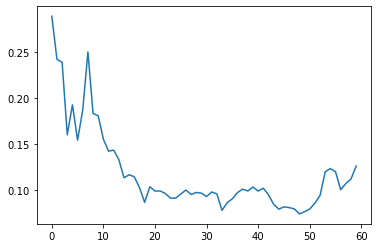

In [17]:
count = 2
y = rate[count]
x = np.arange(0, len(rate[count]))
plt.plot(x, y)

In [53]:
slope = (np.array(deaths_curr) / np.array(cases_past)).mean()

def f(x, m):
    return x * m

mfit, _ = curve_fit(f, cases_past, deaths_curr)
print(slope, mfit)

0.09851779321391586 [0.07636148]


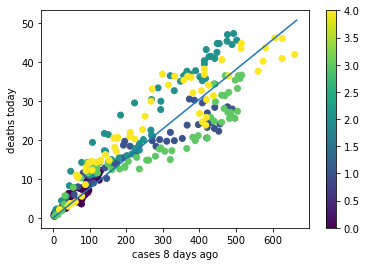

In [54]:
plt.scatter(cases_past, deaths_curr, c=colors)
x = np.linspace(0, np.max(cases_past) + 5, 1000)
plt.plot(x, mfit[0]*x)
plt.xlabel(f'cases {delay} days ago')
plt.ylabel('deaths today')
plt.colorbar()
plt.show()

In [11]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [16]:
scale_factor = np.max(cases_past) / 100
deaths_curr2 = np.array(deaths_curr) / scale_factor
cases_past2 = np.array(cases_past) / scale_factor
def linear(x, m):
    return x * m

mfit = curve_fit(linear, cases_past2, deaths_curr2)[0]
slope = mfit[0]

with pm.Model() as gp_model:

    # Lengthscale
    ρ = pm.HalfCauchy('ρ', 5)
    η = pm.HalfCauchy('η', 5)
    
    M = pm.gp.mean.Linear(coeffs=slope)
    K = (η**2) * pm.gp.cov.ExpQuad(1, ρ)
    
    σ = pm.HalfNormal('σ', 50)
    
#     Xu = pm.gp.util.kmeans_inducing_points(20, cases_past.reshape(-1,1))
    
    deaths_gp = pm.gp.Marginal(mean_func=M, cov_func=K)
    deaths_gp.marginal_likelihood('deaths', X=cases_past2.reshape(-1,1),
                           y=deaths_curr2, noise=σ)

In [17]:
with gp_model:
    gp_trace = pm.sample(100, tune=200, cores=1, random_seed=42)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, η, ρ]
Sampling chain 1, 0 divergences: 100%|███████████████████████████████████████████████████████████████| 300/300 [00:19<00:00, 15.56it/s]
INFO (theano.gof.compilelock): Refreshing lock C:\Users\kehua\AppData\Local\Theano\compiledir_Windows-10-10.0.18362-SP0-AMD64_Family_23_Model_8_Stepping_2_AuthenticAMD-3.7.6-64\lock_dir\lock
The acceptance probability does not match the target. It is 0.9347814225217739, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9344332967028605, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.


In [18]:
X_pred = np.arange(0, np.max(cases_past2)*2)
with gp_model:
    deaths_pred = deaths_gp.conditional("deaths_pred_noise", X_pred.reshape(-1, 1), pred_noise=True)
    gp_samples = pm.sample_posterior_predictive(gp_trace, vars=[deaths_pred], samples=200, random_seed=42)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:16<00:00, 11.90it/s]


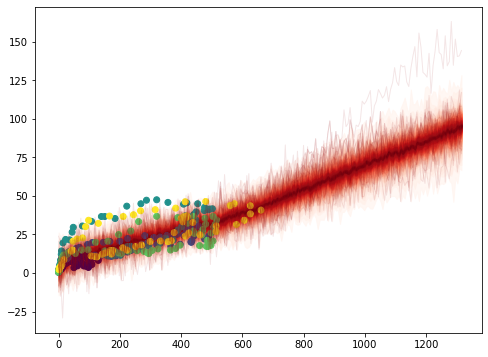

In [19]:
from pymc3.gp.util import plot_gp_dist

fig, ax = plt.subplots(figsize=(8,6))
plot_gp_dist(ax, gp_samples['deaths_pred_noise'] * scale_factor, X_pred * scale_factor)

cases_past3 = cases_past2 * scale_factor
deaths_curr3 = deaths_curr2 * scale_factor

ax.scatter(cases_past3, deaths_curr3, c=colors)
# ax.xlabel(f'cases {delay} days ago')
# ax.ylabel('deaths today')

(25, 35)

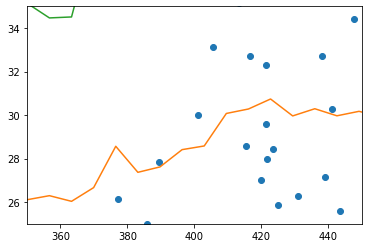

In [26]:
percentiles = [10, 20, 30, 40, 50, 60, 70, 80, 90]
quantile_gp = [np.percentile(gp_samples['deaths_pred_noise'] * scale_factor, q, axis=0)  for q in percentiles]

X_pred2 = X_pred * scale_factor
plt.plot(X_pred2, quantile_gp[0])
plt.plot(X_pred2, quantile_gp[4])
plt.plot(X_pred2, quantile_gp[8])
plt.scatter(cases_past3, deaths_curr3)

plt.xlim(350, 450)
plt.ylim(25, 35)

In [27]:
from scipy.interpolate import interp1d

f = interp1d(X_pred2, quantile_gp[4])
f(np.array([400, 450, 200]))

array([28.50446498, 30.14043974, 17.64984325])

# GP on deaths directly

In [12]:
import theano.tensor as tt

class ExpModel(pm.gp.mean.Mean):

    def __init__(self, max_val, loc, scale, K):
        pm.gp.mean.Mean.__init__(self)
        self.max_val = max_val
        self.loc = loc
        self.scale = scale
        self.K = K

    def __call__(self, X):
        return self.max_val*stats.exponnorm.pdf(X[0], self.K, self.loc, self.scale)

In [15]:
with pm.Model() as gp_model:

    # Lengthscale
    ρ = pm.HalfCauchy('ρ', 5)
    η = pm.HalfCauchy('η', 5)
    
    M = ExpModel(*popt)
    K = (η**2) * pm.gp.cov.ExpQuad(1, ρ) 
    
    σ = pm.HalfNormal('σ', 50)
    
    expnorm_gp = pm.gp.Marginal(mean_func=M, cov_func=K)
    expnorm_gp.marginal_likelihood('expnorm', X=X_train.reshape(-1,1), 
                           y=y_train, noise=σ)

KeyboardInterrupt: 

In [ ]:
with gp_model:
    expnorm_gp_trace = pm.sample(1000, tune=2000, cores=2, random_seed=42)

In [307]:
X_pred = np.arange(0, np.max(X_train) + 30)
with gp_model:
    expnorm_deaths_pred = expnorm_gp.conditional("expnorm_deaths_pred", X_pred.reshape(-1, 1), pred_noise=True)
    gp_samples = pm.sample_posterior_predictive(expnorm_gp_trace, vars=[expnorm_deaths_pred], samples=500, random_seed=42)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 95.64it/s]


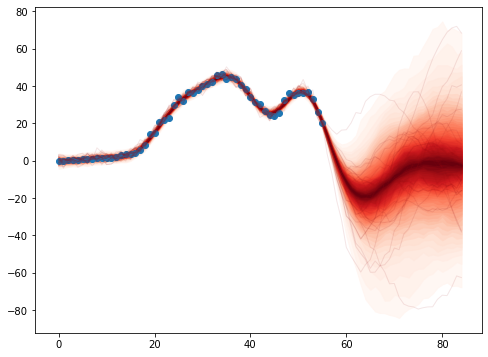

In [308]:
from pymc3.gp.util import plot_gp_dist

fig, ax = plt.subplots(figsize=(8,6))
plot_gp_dist(ax, gp_samples['expnorm_deaths_pred'], X_pred)

ax.scatter(X_train, y_train)

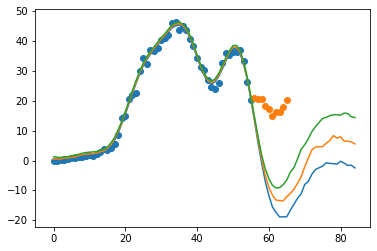

In [309]:
percentiles = [p for p in range(50, 80, 3)]
quantile_gp = [np.percentile(gp_samples['expnorm_deaths_pred'], q, axis=0) for q in percentiles]

plt.plot(X_pred, quantile_gp[0])
plt.plot(X_pred, quantile_gp[4])
plt.plot(X_pred, quantile_gp[8])
plt.scatter(X_train, y_train)
plt.scatter(X_test, y_test)

# plt.xlim(50, 70)
# plt.ylim(-50, 250)

# GP on simulated data from curve fit

In [86]:
d = deaths
x = np.linspace(1, d.shape[0], d.shape[0])
y = model(x, *popt)

residuals = (d - y)[:-validation_steps]
print(residuals)

[ 3.48959919e+00  1.01721798e+00  2.16937107e+00  1.07007693e+01
  2.45937400e-01  1.32865001e+01  5.12489008e+00  1.88747396e+01
 -2.51983860e+00  1.77755032e+01  1.75927339e+01 -1.00850652e+01
 -3.09376782e+01  5.98843300e+01 -9.60786900e+01 -1.14503645e+02
 -1.20295488e+02 -8.97166491e+01 -2.26627426e+02 -9.78048138e+01
 -7.62881075e+01 -2.69691990e+02  4.82565857e+02  2.41569237e+01
  5.08624766e+01  5.07056587e+01 -1.38408561e+01  2.63838647e+01
  1.24567485e+01 -2.44438384e+01  1.20088567e+02  1.00754343e+02
 -3.24384118e+01 -3.69197363e+02 -3.83990831e+02  7.38899581e+02
 -1.16716652e+01  1.22428377e+01  4.46499381e+01  2.45917996e+01
  3.81296507e+01  5.83335058e+01  2.62760529e+01  4.00292532e+01
  1.07662594e+02  1.30242296e+02 -3.31689679e+01 -1.08512087e+02
 -1.26731406e+02  2.26225437e+02 -6.25923150e+01 -4.11383563e+01
  1.04630851e+02 -1.12437566e+01 -8.07236904e+01 -2.67727622e+01
 -2.03569470e+01  2.55574559e+00  5.59953939e+01 -3.10097222e+01
 -1.44330132e+01 -2.92494

In [87]:
s = np.std(residuals)
m = np.mean(residuals)
s, m

(141.35273051820238, 1.8995933826824003)

In [88]:
X_train2 = np.linspace(X_train[0], X_train[-1] + 25, 100)

In [89]:
noise = np.random.normal(loc=m, scale=s, size=X_train2.shape)
y_train2 = model(X_train2, *popt) + noise
y_train2[y_train2 < 0] = 0

In [90]:
print(X_train2.shape, y_train2.shape)

(100,) (100,)


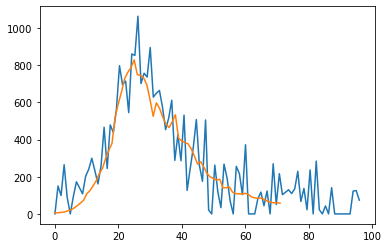

In [91]:
plt.plot(X_train2, y_train2)
plt.plot(X_train, y_train)

In [92]:
with pm.Model() as gp_model:

    # Lengthscale
    ρ = pm.HalfCauchy('ρ', 5)
    η = pm.HalfCauchy('η', 5)
    
    M = ExpModel(*popt)
    K = (η**2) * pm.gp.cov.ExpQuad(1, ρ) 
    
    σ = pm.HalfNormal('σ', 50)
    
    expnorm_gp = pm.gp.Marginal(mean_func=M, cov_func=K)
    expnorm_gp.marginal_likelihood('expnorm', X=X_train2.reshape(-1,1), 
                           y=y_train2, noise=σ)

In [93]:
with gp_model:
    expnorm_gp_trace = pm.sample(500, tune=1000, cores=1, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, η, ρ]
Sampling chain 1, 0 divergences: 100%|███████████████████████████████████████████████████████| 1500/1500 [00:10<00:00, 141.29it/s]


In [94]:
X_pred = np.arange(0, np.max(X_train2) + 30)
with gp_model:
    expnorm_deaths_pred = expnorm_gp.conditional('expnorm_deaths_pred2', X_pred.reshape(-1, 1), pred_noise=True)
    gp_samples = pm.sample_posterior_predictive(expnorm_gp_trace, vars=[expnorm_deaths_pred], samples=150, random_seed=42)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:04<00:00, 36.05it/s]


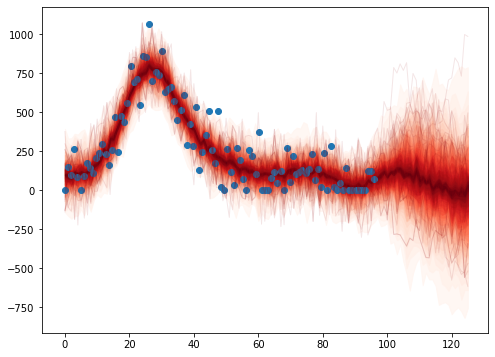

In [95]:
from pymc3.gp.util import plot_gp_dist

fig, ax = plt.subplots(figsize=(8,6))
plot_gp_dist(ax, gp_samples['expnorm_deaths_pred2'], X_pred)

ax.scatter(X_train2, y_train2)

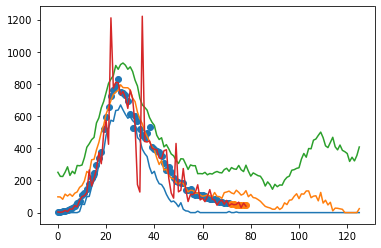

In [96]:
percentiles = [p for p in range(10, 100, 10)]
quantile_gp = [np.percentile(gp_samples['expnorm_deaths_pred2'], q, axis=0) for q in percentiles]
quantile_gp = np.array(quantile_gp)

quantile_gp[quantile_gp < 0] = 0

plt.plot(X_pred, quantile_gp[0])
plt.plot(X_pred, quantile_gp[4])
plt.plot(X_pred, quantile_gp[8])
plt.scatter(X_train, y_train)
plt.scatter(X_test, y_test)

# plt.plot(X_train2, y_train2)
y = deaths
x = np.arange(0, y.shape[0])
plt.plot(x, y)
# plt.xlim(50, 70)
# plt.ylim(-50, 250)

In [97]:
len(quantile_gp[0])

126

In [98]:
pred =quantile_gp[4][X_test]

In [99]:
np.mean(np.abs(pred - y_test)/y_test)

1.4248409784823863

# SARIMAX Residual correction

In [125]:
d = deaths
x = np.linspace(1, d.shape[0], d.shape[0])
y = exp_model(x, *popt)

residuals = (d - y)[:-validation_steps]
print(residuals)

[ -1.16087714  -0.56228547   0.93259591  -2.6907199   -1.44497211
   2.66007175  -5.38114942  -6.56887221  -7.8971441    0.6466591
  -6.9181669  -12.56619225  15.73307645  12.0136599  -17.68876972
   4.6610669   -0.90396344 -24.35520995 -24.6696621   54.16912053
  -9.82937312  15.33755192   6.66642544  16.14860178  -5.22852502
 -23.48022027  -4.62314896  -3.67425778  -4.64986605 -22.56499766
 -11.4329551  -22.26511217 -16.07088638   4.14215523 -27.63189668
  63.60246758   3.8419253   40.08408084  -4.67274911 -27.42971705
  -9.18759125  34.05313045 -12.7078644   33.5292355   -9.23567802
 -22.00266196 -25.77174169  -9.54292345  53.68379772  -2.09156674]


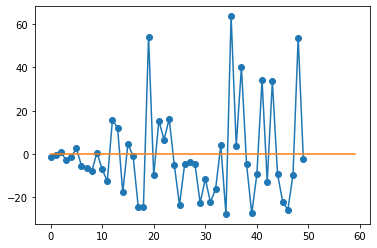

In [126]:
y = residuals
x = np.arange(0, y.shape[0])
plt.plot(x, y, marker='o')

y = np.zeros(y.shape[0] + 10)
x = np.arange(0, y.shape[0])
plt.plot(x, y)

In [157]:
val_steps = 20

In [158]:
train = residuals[:-val_steps]
test = residuals[-val_steps:]

orig_mse = np.sum(test*test) / test.shape[0]
print(orig_mse)

742.3554356240588


In [159]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

#610 - 4, 0, 1, 6
model = SARIMAX(train, seasonal_order=(2, 0, 1, 3))
model = model.fit()
predictions = model.forecast(val_steps)
print(predictions)
history = np.concatenate([train, predictions])

[ 6.5504548   3.03216127 -0.3015669   0.65266877 -0.02160988  4.38810747
 -1.3838319  -0.56525572 -0.83106431  0.15668315  0.11834693 -0.66094104
  0.22974797  0.08285723  0.29065285 -0.07605777 -0.03911258  0.06609169
 -0.02802421 -0.00774439]


In [160]:
predictions = np.array(predictions)
mse = np.sum((predictions - test)**2) / predictions.shape[0]
print(f'mse: {mse}')
print(f'improvement: {orig_mse - mse}')

mse: 737.0678130139733
improvement: 5.287622610085577


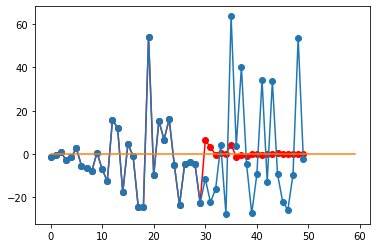

In [161]:
y = np.array(history)
x = np.arange(0, y.shape[0])
plt.plot(x, y, marker='o', color='red')

y = residuals
x = np.arange(0, y.shape[0])
plt.plot(x, y, marker='o')

y = np.zeros(y.shape[0] + 10)
x = np.arange(0, y.shape[0])
plt.plot(x, y)

In [958]:
series = residuals[:-val_steps]

In [959]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf

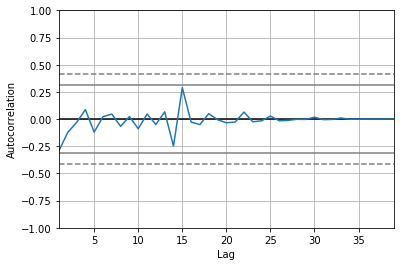

In [960]:
s = pd.Series(series)
autocorrelation_plot(s)

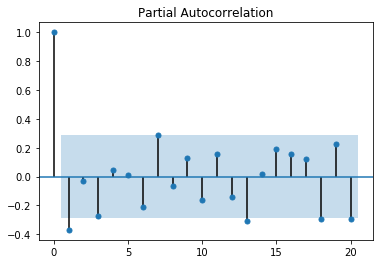

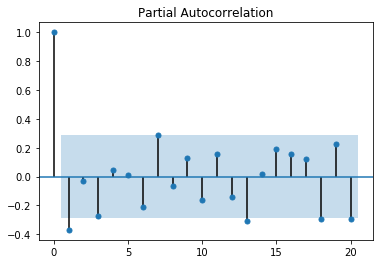

In [863]:
plot_pacf(s, lags=20)